In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_GPU import ZSTL
import timeit

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, True)
])
shape_record = {0: [(1, 9719)]}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
path_data = '../ZSTL_Data/hetrec2011-lastfm-2k/extracted_feature/'
compressed_data = 'sampled_task.pickle'
detailed_data = 'detailed_data.pickle'

with open(path_data+compressed_data, 'rb') as f:
    compressed_dataset = pickle.load(f)

with open(path_data+detailed_data, 'rb') as f:
    detailed_dataset = pickle.load(f)

In [4]:
total_len = len(compressed_dataset)
#print('tot_len ', total_len, compressed_dataset[2])
support_size = 100
test_size = int(total_len*0.2)
train_size = int(total_len - support_size - test_size)
support_loader, train_loader, test_loader = utils.genSplits_hectrec(compressed_dataset, detailed_dataset, train_size, test_size, support_size)

100
1414
378


12523
9719
{'rho': 1e-05, 'mu': 1e-05, 'loss': 'binary class', 'outer lr': 0.001, 'align lr': 0.001, 'dm': 12523, 'd': 9719, 'model_shape': {0: [(1, 9719)]}, 'atten_activation': 'Sparsemax'}
init mean test metric 0.716481481481482; align loss 0.4039665162563324
1/100 o_loss 0.6085087565332651; m train metric 0.7225; m test metric 0.6955555555555555; align loss  0.4040529131889343
10/100 o_loss 0.9225248649716378; m train metric 0.7291; m test metric 0.7156349206349202; align loss  0.4027981460094452
20/100 o_loss 0.8441419326141477; m train metric 0.7287; m test metric 0.7275661375661368; align loss  0.4012296199798584
30/100 o_loss 0.7476005606725812; m train metric 0.7578999999999999; m test metric 0.7362962962962968; align loss  0.399741530418396
40/100 o_loss 0.8120913575589657; m train metric 0.7429999999999999; m test metric 0.743809523809524; align loss  0.39834892749786377
50/100 o_loss 0.8084610546752811; m train metric 0.7447999999999999; m test metric 0.7518518518518511; ali

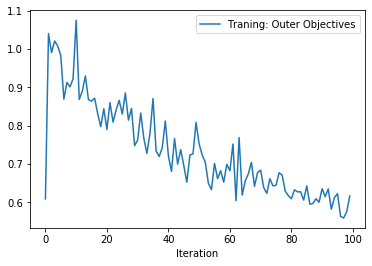

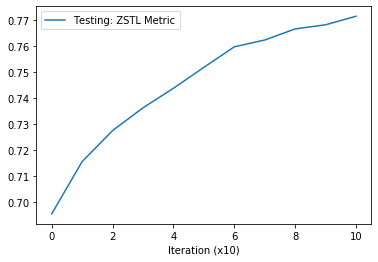

Time: 2457.812821033


In [5]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)

param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 1e-5
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-3
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)


start = timeit.default_timer()
ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=100)
stop = timeit.default_timer()
print('Time:', stop - start)


In [6]:
a = np.array([[1, 0],
           [0, 1],
           [1, 1]])
print(a[a[:,0].argsort()])
print(a[a[:,0].argsort()[::-1]])
print(a[:,0].argsort()[::-1])

[[0 1]
 [1 0]
 [1 1]]
[[1 1]
 [1 0]
 [0 1]]
[2 0 1]


In [7]:
def cal_AvgPrecision_k(pred_y, y, k=5):
    relavance = torch.tensor(0.0, requires_grad=False, dtype=float) #new var
    count = torch.tensor(0.0, requires_grad=False, dtype=float) #new var
    num_data = torch.tensor(y[0,:].size()[0], dtype=float)
    precision = torch.tensor(0.0, requires_grad=False, dtype=float)
    #pos_label = torch.tensor(1.0, )

    #print('pred_y ', pred_y.shape)
    #print('y ', y.shape)
    
    pred_y_sorted_indx = torch.squeeze(torch.argsort(pred_y, dim=0, descending=True))
    #print('pred_y_sorted_indx ', pred_y_sorted_indx)
    pred_y_sorted = pred_y[pred_y_sorted_indx]
    #print('pred_y_sorted ', pred_y_sorted.shape, pred_y_sorted)
    y_sorted = y[pred_y_sorted_indx]
    #print('y_sorted ', y_sorted)

    for i in range(k):
        count += 1
        if y_sorted[i] == 1 :
            relavance += 1
            precision += relavance/count
    
    if relavance == 0:
        return precision
    else:
        precision_atK = precision/relavance
        print('precision_atK ', precision_atK)
        return precision_atK

    
def task_transfer_AvgPrecision(attr_test, x, y, model):
        w_pred = model.task_transfer(attr_test, model.a_kb_opt)
        #print(w_pred.size(), x.size())
        #pred = getPred(x, w_pred, self.model, self.model_shape)
        precision_atK = torch.tensor(0.0, requires_grad=False, dtype=float)
        
        num_task = torch.tensor(y.size()[0], dtype=float)
        for t in range(x.size()[0]):
            cur_w = w_pred[:, t].unsqueeze(0).float()
            pred = model.getPred(x[t,:].float(), cur_w, model.model, model.model_shape)
            
            precision_atK += cal_AvgPrecision_k(pred, y[t,:], k=100)
            #a = ppp
        mAP = precision_atK/num_task
        print('mAP at 100 ', mAP, 'num task ', num_task)
        
        return mAP

In [8]:
total_len = len(compressed_dataset)
#print('tot_len ', total_len, compressed_dataset[2])
support_size = 150
test_size = int(total_len*0.2)
train_size = int(total_len - support_size - test_size)

task_id = list(compressed_dataset.keys())
tot_len = len(task_id)
support_indx = list(np.random.choice(task_id, size=support_size, replace=False))
print(len(support_indx))
temp = [x for x in task_id if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


test_data_selected = utils.Dataset_hetrec([compressed_dataset[d] for d in test_indx], detailed_dataset, phase='Normal')
test_data_full = utils.Dataset_hetrec([compressed_dataset[d] for d in test_indx], detailed_dataset, phase='mAP')

test_data_selected_loader = DataLoader(test_data_selected, batch_size=test_size, shuffle=True)
test_data_full_loader = DataLoader(test_data_full, batch_size=test_size, shuffle=True)

150
1364
378


In [9]:
test_batch = next(iter(test_data_selected_loader))
test_a, test_w, test_x, test_y = test_batch[0].float(), test_batch[1].float(), \
    test_batch[2].float(), test_batch[3].float()
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()
print(test_a.shape, test_w.shape, test_x.shape, test_y.shape)

pred_precision = task_transfer_AvgPrecision(test_a, test_x, test_y, ZSTL_model)

torch.Size([12523, 378]) torch.Size([9719, 378]) torch.Size([378, 100, 9719]) torch.Size([378, 100, 1])
precision_atKtensor(0.9283, dtype=torch.float64)
precision_atK  tensor(0.9101, dtype=torch.float64)
precision_atK  tensor(0.4629, dtype=torch.float64)
precision_atK  tensor(0.9137, dtype=torch.float64)
precision_atK  tensor(0.9177, dtype=torch.float64)
precision_atK  tensor(0.9493, dtype=torch.float64)
precision_atK  tensor(0.8337, dtype=torch.float64)
precision_atK  tensor(0.0588, dtype=torch.float64)
precision_atK  tensor(0.9880, dtype=torch.float64)
precision_atK  tensor(0.7754, dtype=torch.float64)
precision_atK  tensor(0.9421, dtype=torch.float64)
precision_atK  tensor(0.9759, dtype=torch.float64)
precision_atK  tensor(0.9400, dtype=torch.float64)
precision_atK  tensor(0.6418, dtype=torch.float64)
precision_atK  tensor(0.9675, dtype=torch.float64)
precision_atK  tensor(0.8391, dtype=torch.float64)
precision_atK  tensor(0.9521, dtype=torch.float64)
precision_atK  tensor(0.9802, d

In [10]:
test_batch = next(iter(test_data_full_loader))
test_a, test_w, test_y = test_batch[0].float(), test_batch[1].float(), \
    test_batch[2].float()
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()
test_x = utils.toTensor(detailed_dataset['x'])
print(test_a.shape, test_w.shape, test_x.shape, test_y.shape)

#pred_precision = task_transfer_AvgPrecision(test_a, test_x, test_y, ZSTL_model)

torch.Size([12523, 378]) torch.Size([9719, 378]) torch.Size([17632, 9719]) torch.Size([378, 17632, 1])


In [11]:
def ZSTL_AvgPrecision(attr_test, x, y, ZSTL_model):
    w_pred = ZSTL_model.task_transfer(attr_test, ZSTL_model.a_kb_opt)
    #print(w_pred.size(), x.size())
    #pred = getPred(x, w_pred, self.model, self.model_shape)
    precision_atK = torch.tensor(0.0, requires_grad=False, dtype=float)
    
    num_task = torch.tensor(y.size()[0], dtype=float)
    for t in range(y.size()[0]):
        cur_w = w_pred[:, t].unsqueeze(0).float()
        pred = ZSTL_model.getPred(x.float(), cur_w, ZSTL_model.model, ZSTL_model.model_shape)
        #print(y[t,:].shape)
        precision_atK += cal_AvgPrecision_k(pred, y[t,:], k=100)
        #a = ppp
    mAP = precision_atK/num_task
    print('mAP at 100 ', mAP, 'num task ', num_task)
    
    return mAP

In [12]:
'''
use all data
'''
pred_precision = ZSTL_AvgPrecision(test_a, test_x, test_y, ZSTL_model)

precision_atK  tensor(0.1079, dtype=torch.float64)
precision_atK  tensor(0.0913, dtype=torch.float64)
precision_atK  tensor(0.5293, dtype=torch.float64)
precision_atK  tensor(0.1903, dtype=torch.float64)
precision_atKtensor(0.1926, dtype=torch.float64)
precision_atK  tensor(0.2054, dtype=torch.float64)
precision_atK  tensor(0.2314, dtype=torch.float64)
precision_atK  tensor(0.1379, dtype=torch.float64)
precision_atK  tensor(0.4281, dtype=torch.float64)
precision_atK  tensor(0.2393, dtype=torch.float64)
precision_atK  tensor(0.3786, dtype=torch.float64)
precision_atK  tensor(0.6757, dtype=torch.float64)
precision_atK  tensor(0.1673, dtype=torch.float64)
precision_atK  tensor(0.2801, dtype=torch.float64)
precision_atK  tensor(0.2810, dtype=torch.float64)
precision_atK  tensor(0.2315, dtype=torch.float64)
precision_atK  tensor(0.1205, dtype=torch.float64)
precision_atK  tensor(0.2823, dtype=torch.float64)
precision_atK  tensor(0.3090, dtype=torch.float64)
precision_atK  tensor(0.0833, dty